# Testing a Random Forests model

Originally had deleted rows with leks that had only been detected for one year (active_count = 1) and that had been active for one year (active_percent = 100). 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load your data (example)
data = pd.read_csv("E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/unk_loc_leks/rf_regression_leks_redo_clean.csv")
df = data.drop(columns = ['lek', 'y_northing', 'x_easting', 'active_percent', 'hr_hub_score', 'rnd_trip_hub_score', 'rnd_trip_centrality_score', 'k_hub_score'])

# Define features (X) and target variable (y)
X = df[['max_dsp_hub_score', 'max_dsp_centrality_score', 'avg_dsp_centrality_score', 'avg_dsp_hub_score', 'hr_centrality_score', 'k2_hub_score', 'k2_centrality_score', 'k_centrality_score', ]]
y = df['years_since_active']

# Split into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=1000, max_depth = 8, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns

# Print feature importance
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")

Mean Squared Error (MSE): 89.7210
Mean Absolute Error (MAE): 7.5744
R² Score: 0.3479
max_dsp_hub_score: 0.3843
max_dsp_centrality_score: 0.0920
avg_dsp_centrality_score: 0.1083
avg_dsp_hub_score: 0.1242
hr_centrality_score: 0.0882
k2_hub_score: 0.0398
k2_centrality_score: 0.0994
k_centrality_score: 0.0639


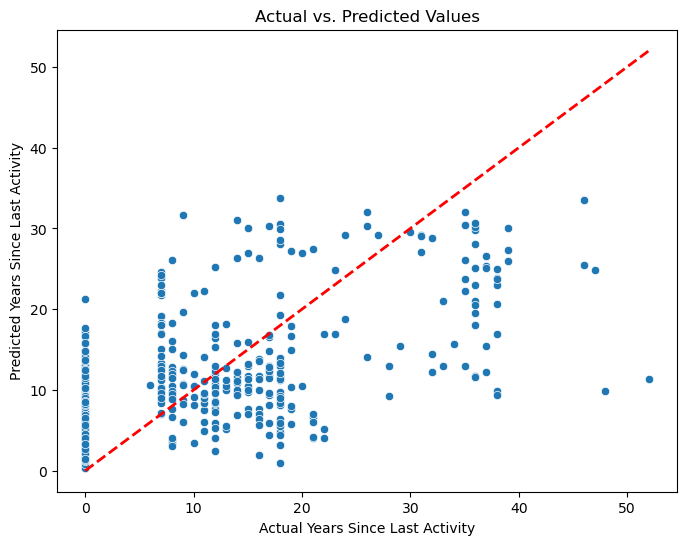

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)  # Perfect prediction line
plt.xlabel("Actual Years Since Last Activity")
plt.ylabel("Predicted Years Since Last Activity")
plt.title("Actual vs. Predicted Values")
plt.show()

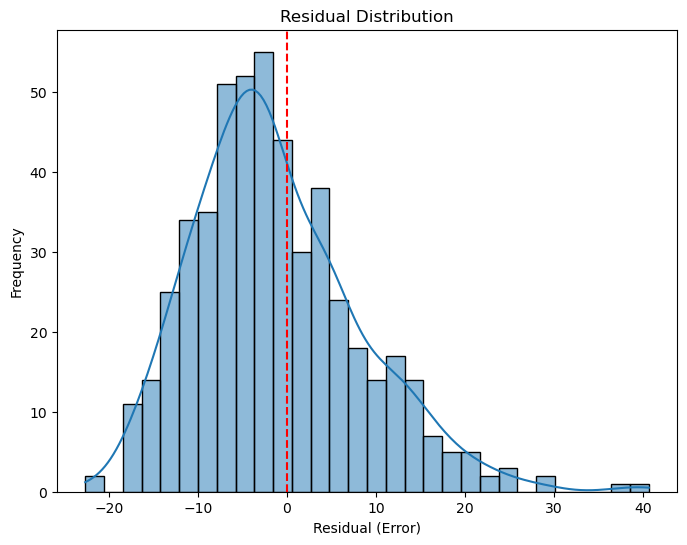

In [4]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

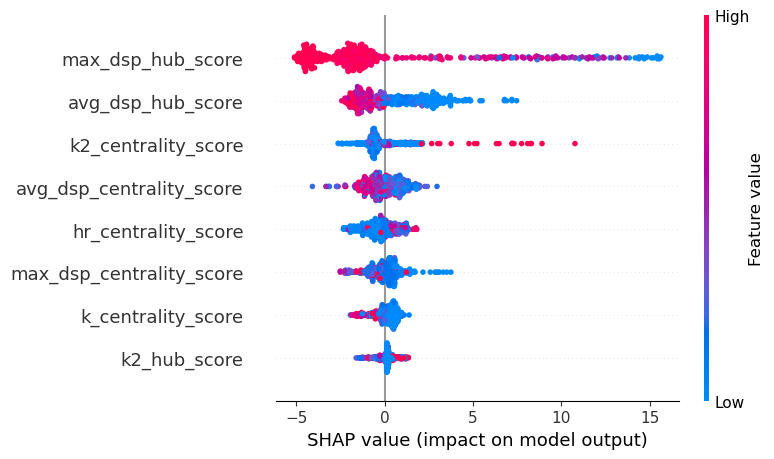

In [6]:
import shap

explainer = shap.TreeExplainer(rf)  # Use TreeExplainer for tree-based models
shap_values = explainer.shap_values(X_test)

# Print summary statistics
shap.summary_plot(shap_values, X_test)

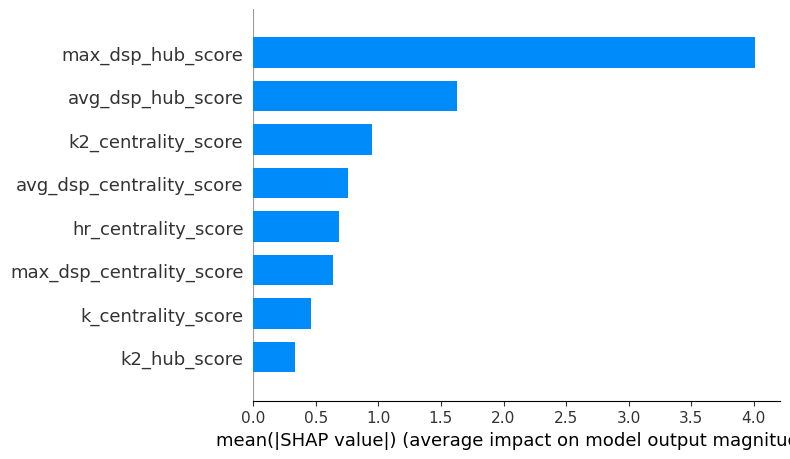

In [8]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display = 10)

In [7]:
# Pick one test sample (e.g., the first one)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

In [135]:
# Reload the dataset to include coordinates
df_with_coords = data[['lek', 'y_northing', 'x_easting']].copy()  # Keep lek name and coordinates

# Add predictions to the DataFrame
df_with_coords['predicted_years_since_active'] = rf.predict(X)

# Print a preview
print(df_with_coords.head())

df_with_coords.to_csv('E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/unk_loc_leks/rf_regression_predictions.csv', index=False)

     lek  y_northing  x_easting  predicted_years_since_active
0  11625     3726555     672030                      1.468010
1  11665     3727697     675593                      0.928476
2  11667     3727697     677202                      7.462780
3  11724     3730916     654671                      3.419251
4  11731     3775466     600308                      6.027222


In [132]:
import geopandas as gpd
from shapely.geometry import Point

# Convert to a GeoDataFrame
geometry = [Point(x, y) for x, y in zip(df_with_coords['x_easting'], df_with_coords['y_northing'])]
gdf = gpd.GeoDataFrame(df_with_coords, geometry=geometry, crs="EPSG:26913")

# Transform to WGS84 (lat/lon) for basemap visualization
gdf = gdf.to_crs("EPSG:4326")

# Print a preview with lat/lon
print(gdf[['lek', 'geometry', 'predicted_years_since_active']].head())



     lek                     geometry  predicted_years_since_active
0  11625  POINT (-103.14453 33.66498)                      1.468010
1  11665  POINT (-103.10589 33.67469)                      0.928476
2  11667  POINT (-103.08855 33.67442)                      7.462780
3  11724  POINT (-103.33093 33.70696)                      3.419251
4  11731  POINT (-103.91236 34.11522)                      6.027222


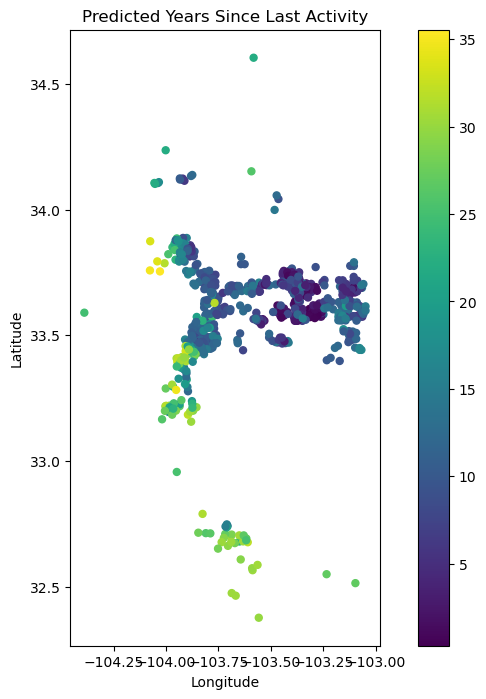

In [134]:
import matplotlib.pyplot as plt

# Plot the map
fig, ax = plt.subplots(figsize=(10,8))
gdf.plot(column='predicted_years_since_active', cmap='viridis', markersize=25, legend=True, ax=ax)

# Set labels
ax.set_title("Predicted Years Since Last Activity")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

# XGBoost

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load your data (example)
data = pd.read_csv("E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/unk_loc_leks/rf_regression_leks_redo_clean.csv")
df = data.drop(columns = ['lek', 'y_northing', 'x_easting', 'active_percent', ])

# Define features (X) and target variable (y)
X = df[['max_dsp_hub_score', 'max_dsp_centrality_score', 'avg_dsp_centrality_score', 'avg_dsp_hub_score', 'hr_centrality_score', 'k2_hub_score', 'k2_centrality_score', 'k_centrality_score', 'hr_hub_score', 'rnd_trip_hub_score', 'k_hub_score']]
y = df['years_since_active']

# Split into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # For regression tasks
    n_estimators=1000,  # Number of trees (increase for better results)
    learning_rate=0.1,  # Step size shrinkage
    max_depth=10,  # Tree depth
    subsample=0.7,  # Row sampling ratio
    colsample_bytree=0.8,  # Feature sampling ratio per tree
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 94.5246
Mean Absolute Error (MAE): 7.5782
R² Score: 0.3130


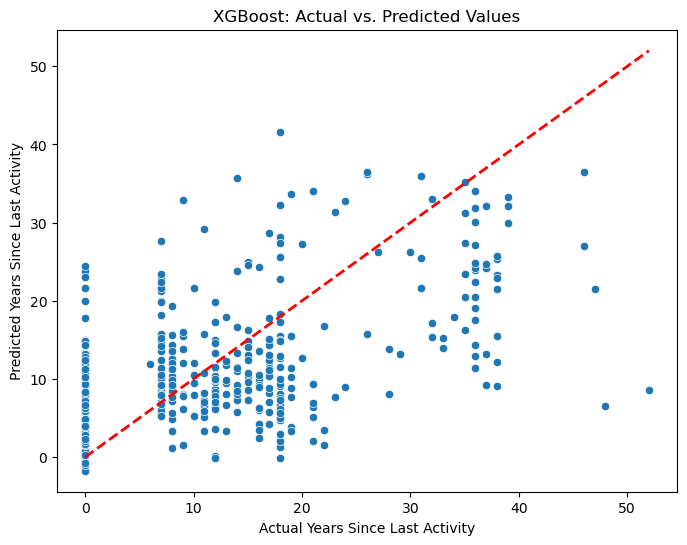

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)  # Perfect prediction line
plt.xlabel("Actual Years Since Last Activity")
plt.ylabel("Predicted Years Since Last Activity")
plt.title("XGBoost: Actual vs. Predicted Values")
plt.show()

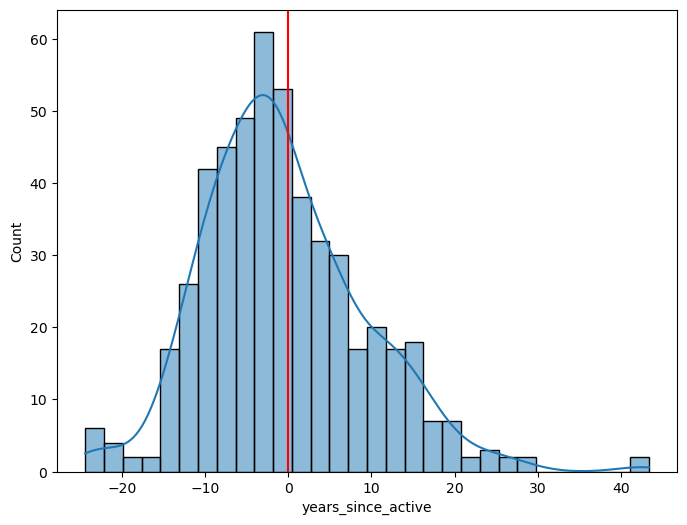

In [5]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='r')